# 3D Deblending on synthetic data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops
from scipy.sparse.linalg import eigsh as sp_eigsh
from pylops import LinearOperator

from pylops.waveeqprocessing import BlendingContinuous
#from torch.utils.data import TensorDataset, DataLoader
from pylops.optimization.basic import lsqr
from pylops.signalprocessing import Patch3D

from utils import *
from visual import *

Ingest data and plot sources and receivers grid

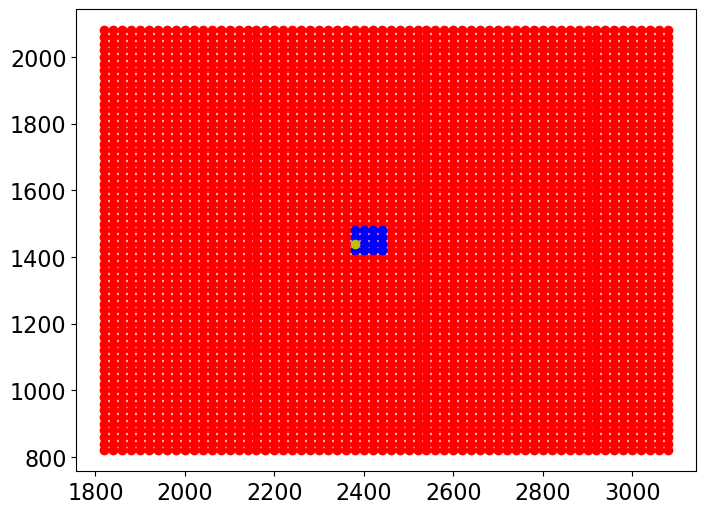

In [2]:
f = np.load('../data/Ove3D_cropped_for_deblending.npz')
srcx, srcy = f['srcx'], f['srcy']
recx, recy = f['recx'], f['recy']
t = f['t']
dt = t[1]
data = f['data']

data = data[..., :480]
t = t[:480]
nt = len(t)

plt.figure()
plt.scatter(srcx, srcy, c='r')
plt.scatter(recx, recy, c='b');
plt.scatter(recx[4], recy[4], c='y');

Retrieveng one Common Receiver Gather:

In [3]:
data_rec = data[:, 4:5]
data_rec = data_rec.reshape(64, 64, t.size)

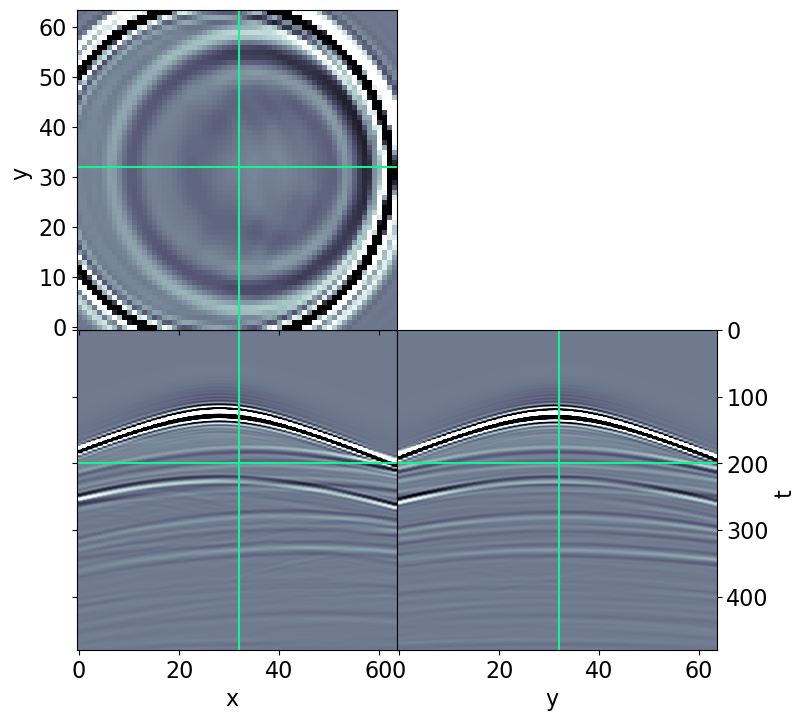

In [67]:
explode_volume(data_rec.transpose(2, 1, 0), t=200, vmin=-1e-4, vmax=1e-4);

Creating firing times that will be used to construct the Blending Operator, having 64 sources in the X direction and 64 in Y:

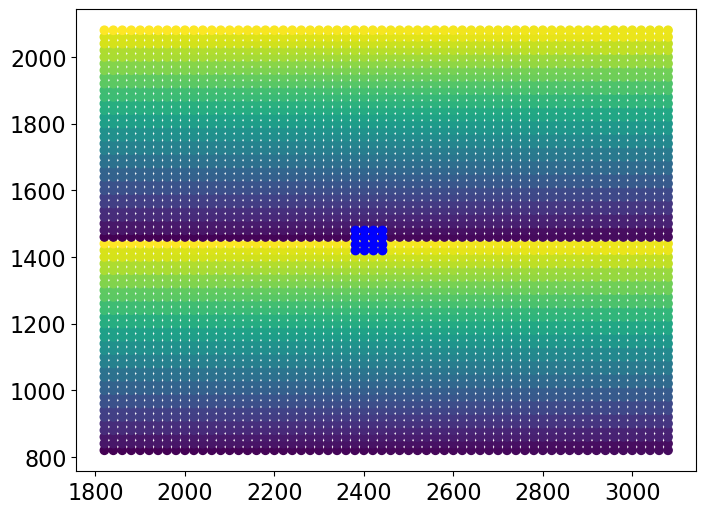

In [5]:
set_seed(42)

nsx, nsy = 64, 64

firing = np.zeros((nsy, nsx))
firing[:nsy//2,:] = np.arange(nsx*nsy//2).reshape(nsy//2, nsx)
firing[nsy//2:,:] = np.arange(nsx*nsy//2).reshape(nsy//2, nsx)

# mimic boat going left right / right left
for i in range(1, nsy//2, 2):
    firing[i] = np.flipud(firing[i])
for i in range(nsy//2+1, nsy, 2):
    firing[i] = np.flipud(firing[i])

firingjit = firing + np.random.normal(0, .05, firing.shape)

firingjit[firingjit>firing.max()] = firing.max()
firingjit[firingjit<0] = 0

plt.figure()
plt.scatter(srcx, srcy, c=firing.ravel())
plt.scatter(recx, recy, c='b');

## Blending the CRG with the obtained firing times

In [6]:
ns = srcx.size
nt = t.size
nr = 1

Bop = BlendingContinuous(nt, 1, ns, dt, firingjit.ravel(), dtype = 'complex128')

In [7]:
# Blending data
dblend = Bop * data_rec.reshape(nsx*nsy, 1, nt)
dblend.shape

(1, 512231)

## Applying the adjoint of the Blending Operator to Pseudodeblend the data

In [8]:
dpseudo = Bop.H * dblend
dpseudo_to_patch = dpseudo.reshape(nsx, nsy, nt)
dpseudo_to_patch.shape

(64, 64, 480)

Plotting pseudodeblended data

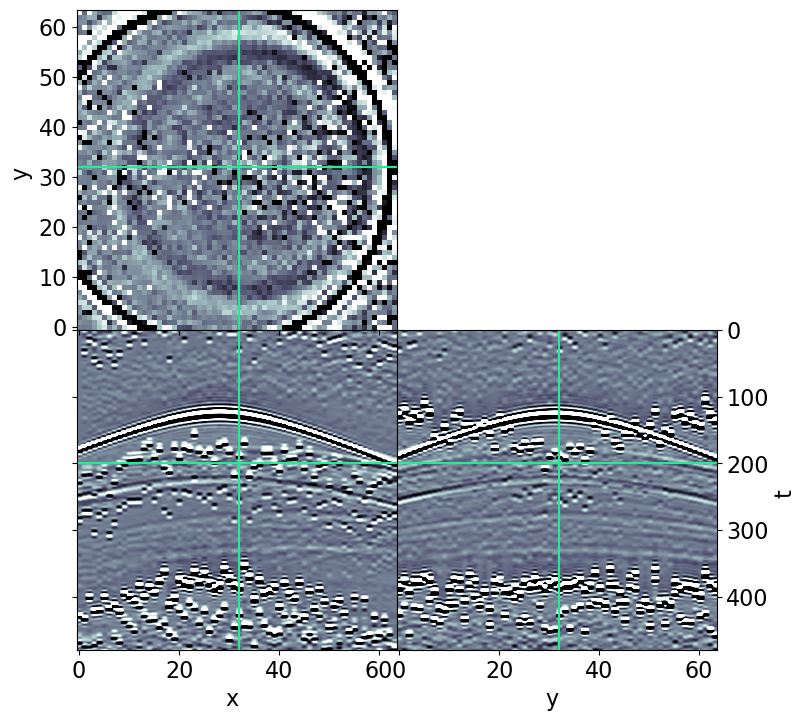

In [66]:
explode_volume(np.real(dpseudo_to_patch).transpose(2, 1, 0), t=200, vmin=-1e-4, vmax=1e-4);

Before deblending our dataset, we need to create an operator that performs patched FFT in 3D. So it's important to play a little bit with the parameters of window size and overlap for the patches creation, since they affect the reconstruction of our signal and are chosen manually. 

## Creating 3D Patching Operator

Window and Overlap Parameters:

In [10]:
#nwin = (8, 8, 32)  # window size in data domain
#nfft = (32, 32, 128)  # fft size
#nfft2 = (32, 32, 128//2+1)  # fft size
#nover = (4, 4, 16)  # overlap between windows

nwin = (16, 16, 32)  # window size in data domain
nfft = (32, 32, 64)  # fft size
nfft2 = (32, 32, 64//2+1)  # fft size
nover = (8, 8, 16)  # overlap between windows

FFT parameters:

In [11]:
dimsd = dpseudo_to_patch.shape
nop = nfft2 # window size in model domain; we use real FFT, third axis is half

FFT Operator

In [12]:
Fop = pylops.signalprocessing.FFTND(nwin, nffts=nfft, real=True)

In [13]:
nwins, dims, mwin_inends, dwin_inends = pylops.signalprocessing.patch3d_design(
    dimsd, nwin, nover, nfft2
)

 288 304 320 336 352 368 384 400 416 432 448], end:[ 32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288 304
 320 336 352 368 384 400 416 432 448 464 480]
 594 627 660 693 726 759 792 825 858 891 924], end:[ 33  66  99 132 165 198 231 264 297 330 363 396 429 462 495 528 561 594
 627 660 693 726 759 792 825 858 891 924 957]


Patching operators

In [14]:
Sop1 = pylops.signalprocessing.Patch3D(
    Fop.H, dims, dimsd, nwin, nover, nop, tapertype='none'
)

Sop = pylops.signalprocessing.Patch3D(
    Fop.H, dims, dimsd, nwin, nover, nop, tapertype='hanning'
)

### Reconstructing test

We use this test to check how our chosen parameters affect the reconstruction of the data

Apply FFT on 3D patches from pseudodeblended data

In [15]:
fft_patched = Sop1.H * dpseudo_to_patch
fft_patched.shape

(7, 7, 29, 32, 32, 33)

Putting the patches back together and returning the data to the time domain

In [16]:
recovered_data = Sop * fft_patched
recovered_data.shape

(64, 64, 480)

Difference:

In [17]:
np.linalg.norm(recovered_data - dpseudo_to_patch) / np.linalg.norm(recovered_data)

2.2682807190805744e-16

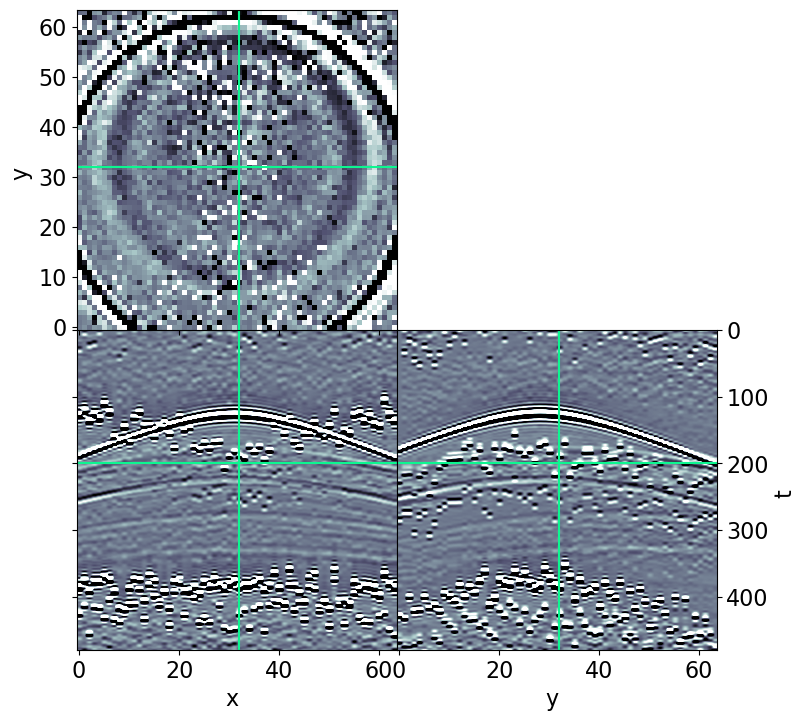

In [68]:
explode_volume(np.real(dpseudo_to_patch.transpose(2,0,1)), t=200, vmin=-1e-4, vmax=1e-4);

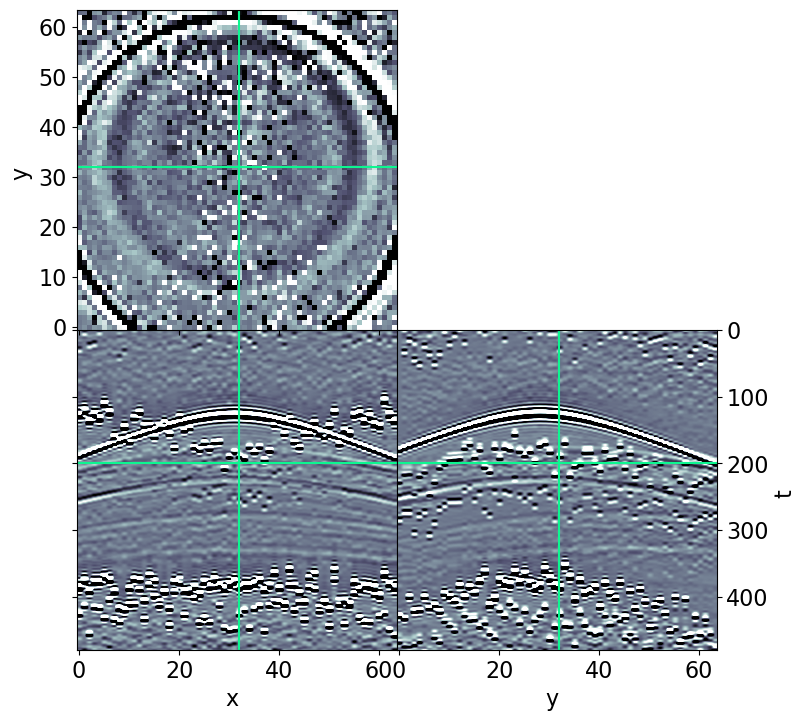

In [69]:
explode_volume(np.real(recovered_data.transpose(2,0,1)), t=200, vmin=-1e-4, vmax=1e-4);

## FK-Spectra

In [20]:
dclean_to_patch = data_rec.reshape(nsx,nsy,t.size)

In [21]:
p_clean = Sop1.H * dclean_to_patch
p_clean.shape

(7, 7, 29, 32, 32, 33)

In [22]:
p_pseudo = Sop1.H * dpseudo_to_patch
p_pseudo.shape

(7, 7, 29, 32, 32, 33)

Chosing a patch to plot:

In [23]:
#Large windows
chosen_patch = [3,3,12
               ]

#Smaller windows
#chosen_patch = [1,12,119//2]

Obtaining the spectrum for clean data patch

Extracting a specific patch from the clean data

In [24]:
patch_cleanfft = p_clean[chosen_patch[0],chosen_patch[1],chosen_patch[2]]
patch_cleanfft.shape

(32, 32, 33)

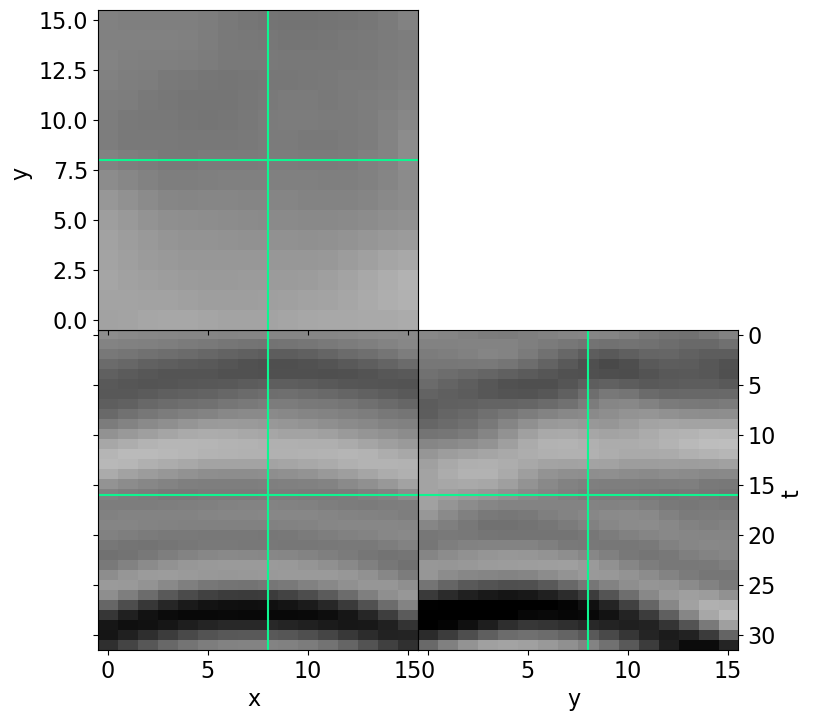

In [25]:
explode_volume((Fop.H @ patch_cleanfft).transpose(2, 0, 1), cmap='gray');

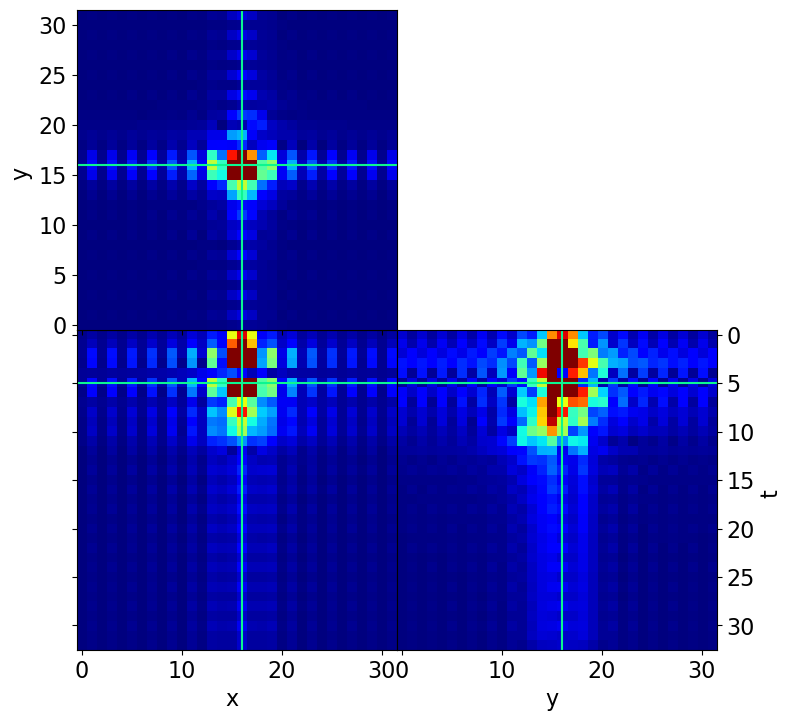

In [26]:
#FK Spectrum
explode_volume(np.fft.fftshift(np.abs(patch_cleanfft), axes=(0,1)).transpose(2, 0, 1), t=5,
               cmap='jet', vmin=0, vmax=1e-4);

Extracting a specific patch from the pseudodeblended data

In [27]:
patch_pseudofft = p_pseudo[chosen_patch[0],chosen_patch[1],chosen_patch[2]]
patch_pseudofft.shape

(32, 32, 33)

FK Spectrum of the whole 3D patch

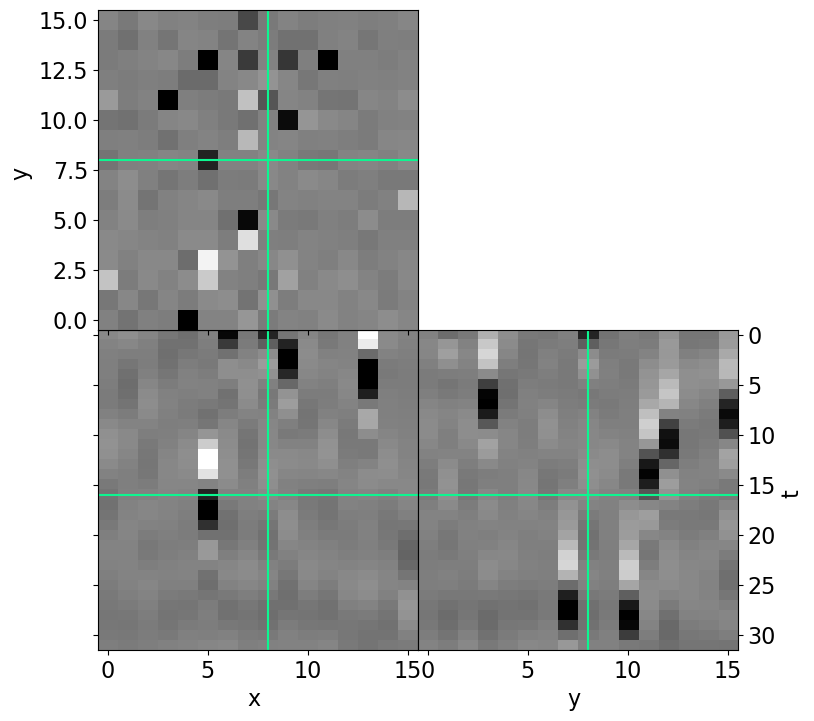

In [28]:
explode_volume((Fop.H @ patch_pseudofft).transpose(2, 0, 1), cmap='gray');

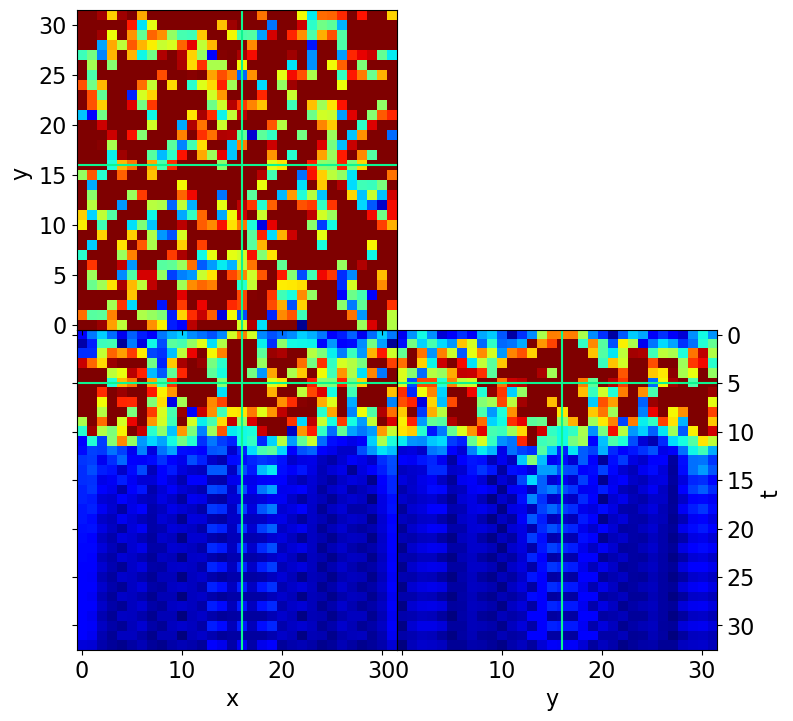

In [29]:
#FK Spectrum
explode_volume(np.fft.fftshift(np.abs(patch_pseudofft), axes=(0,1)).transpose(2, 0, 1), t=5,
               cmap='jet', vmin=0, vmax=1e-4);

## Inversion

In [30]:
Op = Bop * Sop

Only run this cell if you have not computed this value before

In [31]:
# # Compute max eigenvalue (we do this explicitly to be able to run this fast)
#Op1 = LinearOperator(Op.H * Op, explicit=False)
#maxeig = sp_eigsh(Op1, k=1, ncv=10, maxiter=10, tol=1e-2)[0]
maxeig = (Op.H * Op).eigs(1, niter=4, ncv=3, tol=1e-1)
alpha = 1.0 / np.real(maxeig[0])
print(alpha)

0.19958811240561


In [88]:
# Deblend
niter = 150
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2

p_inv = pylops.optimization.sparsity.fista(
    Op,
    dblend.ravel(),
    niter=niter,
    eps=8e-5,#1e-4
    alpha=alpha,
    decay=decay,
    show=True,
)[0]

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 512231 rows and 48018432 cols
eps = 8.000000e-05	tol = 1.000000e-10	niter = 150
alpha = 1.995881e-01	thresh = 7.983524e-06
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    3.995e-03   5.700e-03   2.149e-02
     2   0.00e+00+0.00e+00j    2.726e-03   5.353e-03   1.397e-02
     3   0.00e+00+0.00e+00j    1.876e-03   5.173e-03   1.277e-02
     4   0.00e+00+0.00e+00j    1.339e-03   5.061e-03   1.134e-02
     5   0.00e+00+0.00e+00j    1.004e-03   4.953e-03   1.016e-02
     6   0.00e+00+0.00e+00j    7.904e-04   4.831e-03   9.313e-03
     7   0.00e+00+0.00e+00j    6.489e-04   4.697e-03   8.729e-03
     8   0.00e+00+0.00e+00j    5.504e-04   4.557e-03   8.307e-03
     9   0.00e+00+0.00e+00j    4.782e-04   4.420e-03   7.978e-03
    10   0.00e+00+0

In [89]:
data_inv = Sop * p_inv
data_inv = data_inv.reshape(nsx, nsy, nt)

Deblended data

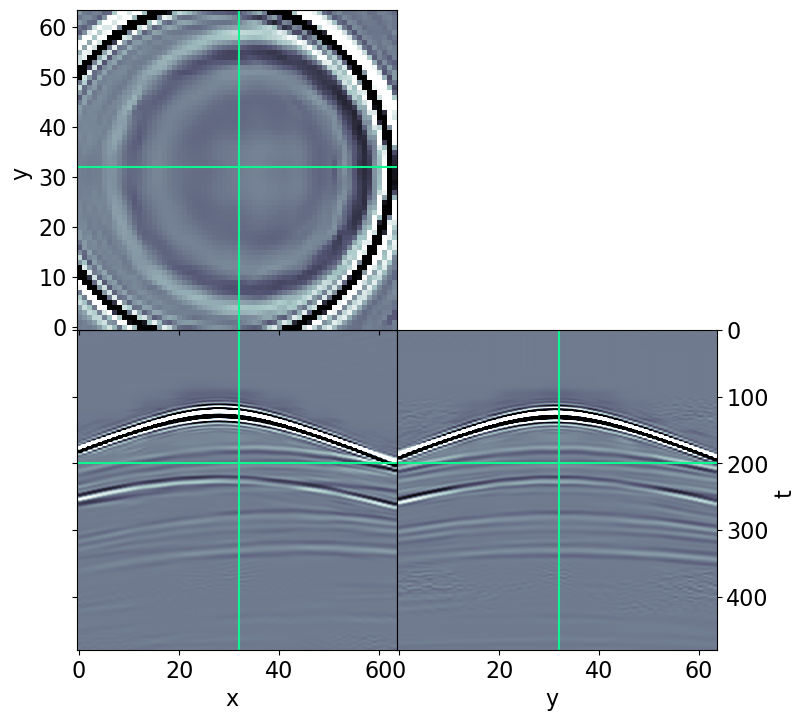

In [90]:
explode_volume(np.real(data_inv).transpose(2, 1, 0), t=200, vmin=-1e-4, vmax=1e-4);

Norm

In [91]:
np.linalg.norm(np.real(data_inv) - dclean_to_patch) / np.linalg.norm(dclean_to_patch)

0.07172914805920433

Difference

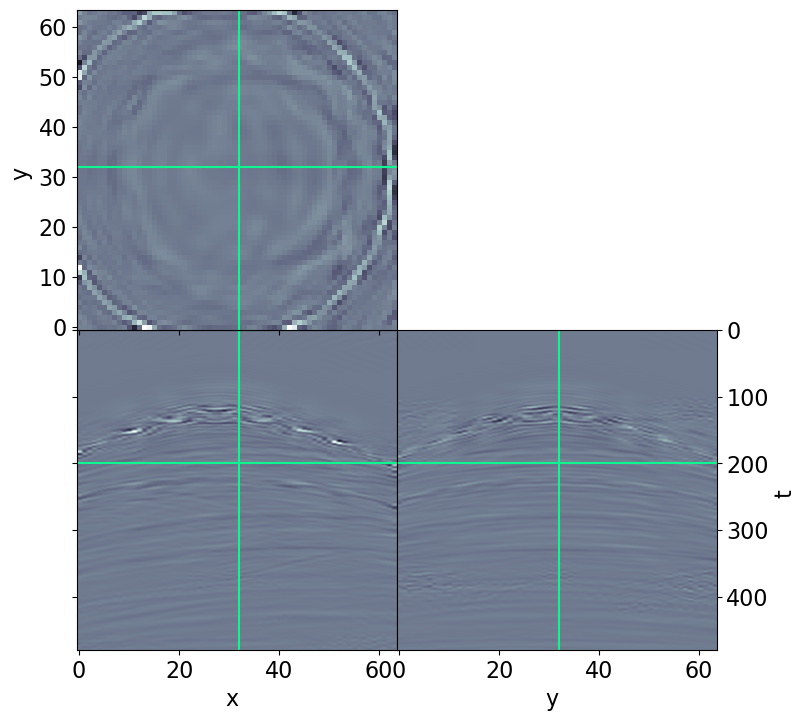

In [92]:
diff = np.real(data_inv) - dclean_to_patch
explode_volume(diff.transpose(2, 1, 0), t=200, vmin=-1e-4, vmax=1e-4);

In [93]:
p_debl = Sop1.H * data_inv

patch_deblfft = data_inv[chosen_patch[0],chosen_patch[1],chosen_patch[2]]
patch_deblfft.shape

()

In [94]:
patch_deblfft = p_debl[chosen_patch[0],chosen_patch[1],chosen_patch[2]]
patch_deblfft.shape

(32, 32, 33)

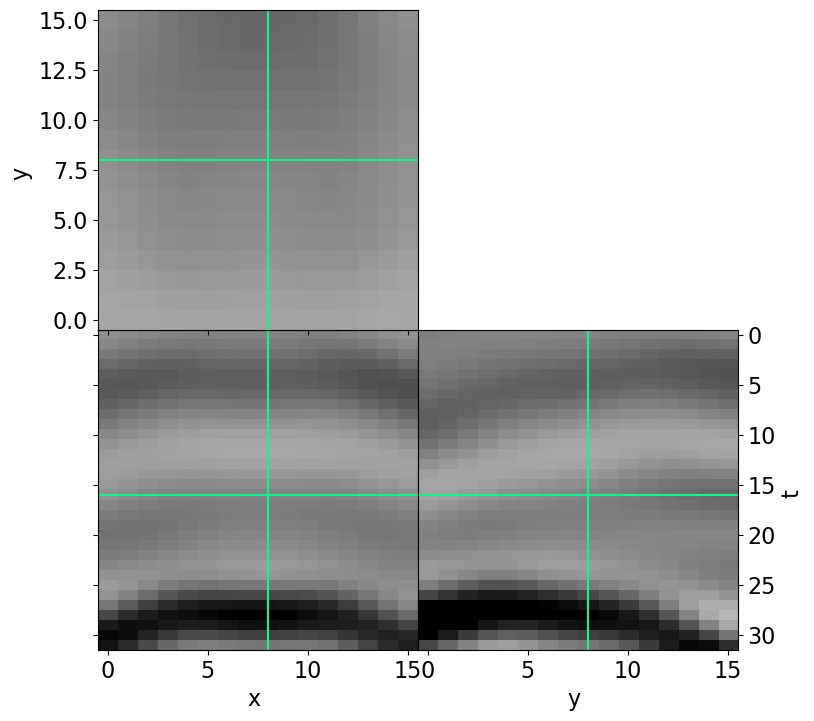

In [95]:
explode_volume((Fop.H @ patch_deblfft).transpose(2, 0, 1), cmap='gray');

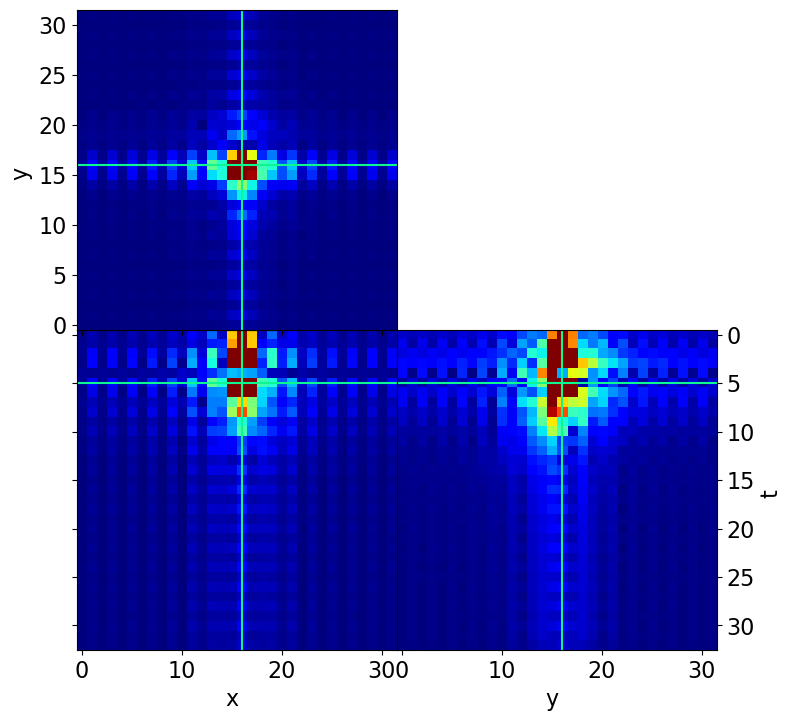

In [96]:
#FK Spectrum
explode_volume(np.fft.fftshift(np.abs(patch_deblfft), axes=(0,1)).transpose(2, 0, 1), t=5,
               cmap='jet', vmin=0, vmax=1e-4);